In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression

In [3]:
from urllib.request import urlopen
import plotly.express as px
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

import pandas as pd


## Load and prep data tables

In [4]:
# Load in and clean up the COVID dataset
covid = pd.read_csv("https://raw.githubusercontent.com/salvir1/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/07-31-2020.csv", dtype={"FIPS": str})
covid.head(2)

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,45001,Abbeville,South Carolina,US,2020-08-01 04:36:27,34.223334,-82.461707,282,7,0,275.0,"Abbeville, South Carolina, US",1149.753333,2.482270
1,22001,Acadia,Louisiana,US,2020-08-01 04:36:27,30.295065,-92.414197,2331,71,0,2260.0,"Acadia, Louisiana, US",3756.950600,3.045903


In [5]:
covid = covid[covid['Country_Region'] == 'US']

# Converting FIPS to str of length 5 with leading zeroes if short. 
new_fips = [str(i).zfill(5) for i in covid['FIPS']]
covid.iloc[:,0] = new_fips
covid['COVID_Incidence_Rate'] = covid['Incidence_Rate'] / 100000

covid = covid[['FIPS', 'COVID_Incidence_Rate', 'Country_Region', 'Lat', 'Long_']]

covid.head(2)

,FIPS,COVID_Incidence_Rate,Country_Region,Lat,Long_
0,45001,0.011498,US,34.223334,-82.461707
1,22001,0.037570,US,30.295065,-92.414197


In [6]:
# Load in and clean up the hiv dataset
hiv = pd.read_csv('data/merged_data.csv', dtype={"county_code": str})
hiv.head(2)

,Unnamed: 0,county_code,COUNTY,STATEABBREVIATION,YEAR,AMAT_fac,HIVdiagnoses,HIVincidence,HIVprevalence,MH_fac,...,pctunmetneed,nonmedpain,ADULTMEN,MSM12MTH,MSM5YEAR,%msm12month,%msm5yr,unemployment_rate,poverty_rate,household_income
0,0,1001,Autauga County,AL,2015,0.0,5.0,10.9,225.5,1.0,...,95.70,5.12,19410,333,514,1.715611,2.648120,8.5,12.8,20304
1,1,1003,Baldwin County,AL,2015,0.0,15.0,8.7,163.9,4.0,...,91.34,5.27,69724,925,1429,1.326659,2.049509,8.6,13.8,73058


In [7]:
new_FIPS = [str(i).zfill(5) for i in hiv['county_code']]
hiv['FIPS'] = new_FIPS
hiv['ST'] = hiv['STATEABBREVIATION']

# Setting bad datapoint (HIV incidence = 771.4) to 0
hiv.loc[hiv['HIVincidence']>700] = 0
hiv = hiv[['FIPS', "COUNTY", "ST", "HIVprevalence", "unemployment_rate", "poverty_rate", "household_income", "Population"]]

In [8]:
hiv_cov = hiv.merge(covid, how='left', on = 'FIPS')
hiv_cov.dropna(inplace=True)
hiv_cov.head(2)

,FIPS,COUNTY,ST,HIVprevalence,unemployment_rate,poverty_rate,household_income,Population,COVID_Incidence_Rate,Country_Region,Lat,Long_
0,01001,Autauga County,AL,225.5,8.5,12.8,20304,55035.0,0.017398,US,32.539527,-86.644082
1,01003,Baldwin County,AL,163.9,8.6,13.8,73058,203690.0,0.013690,US,30.727750,-87.722071


## Create visualizations
- Create maps of COVID incidence rates by county and HIV prevalence by county. While incidence and prevalence are two different measures, in this case each may be the best metric of the underlying epidemic. 
- Fortunately, HIV is much less common than COVID, so incidence numbers are smaller--even nonexistent (or at least not reported) in many counties. Prevalence--while not perfect--is the most accurate measure of the penetration of the disease. The downsides are that it doesn't necessarily indicate where the disease was contracted since people are mobile. 
- For COVID, incidence is the only measure that makes sense since it is not a persistent illness. 
- Scatter matrix of COVID by HIV. The issue with the data that the scatter matrix demonstrates clearly is that the regional strength of signal may not translate down to the county level. I.e. while the map suggests a strong geographic trend, the trend may not be as apparent at the county level. Perhaps there's too much point variation. One approach to addressing this problem could be to regionalize the data by creating KNN Regressor predictions. The approach would to calculate a KNN mapping of an epidemic predictor from the covid data and separately for the hiv data, and then compare each of the KNN mappings. This approach was taken a KNN of 10 to 'regionalize' the hiv data and the covid data. These maps are presented after the original maps.


In [9]:
fig = px.choropleth_mapbox(hiv_cov, geojson=counties, locations='FIPS', color='COVID_Incidence_Rate',
                           color_continuous_scale="Viridis",
                           range_color=(0, 0.022),
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'COVID_Incidence_Rate':'COVID Incidence Rate 7/31/2020'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image("img/July_31_covid_map.png")
fig.write_html('img/July_31_covid_map.html', auto_open=True)


In [10]:
fig = px.choropleth_mapbox(hiv_cov, geojson=counties, locations='FIPS', color='HIVprevalence',
                           color_continuous_scale="Viridis",
                           range_color=(0, 325),
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'HIVprevalence':'HIV prevalence'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image("img/hiv_prev_map.png")
fig.write_html('img/hiv_prev_map.html', auto_open=True)

Text(0.5, 1.0, 'Red line is regression model.')

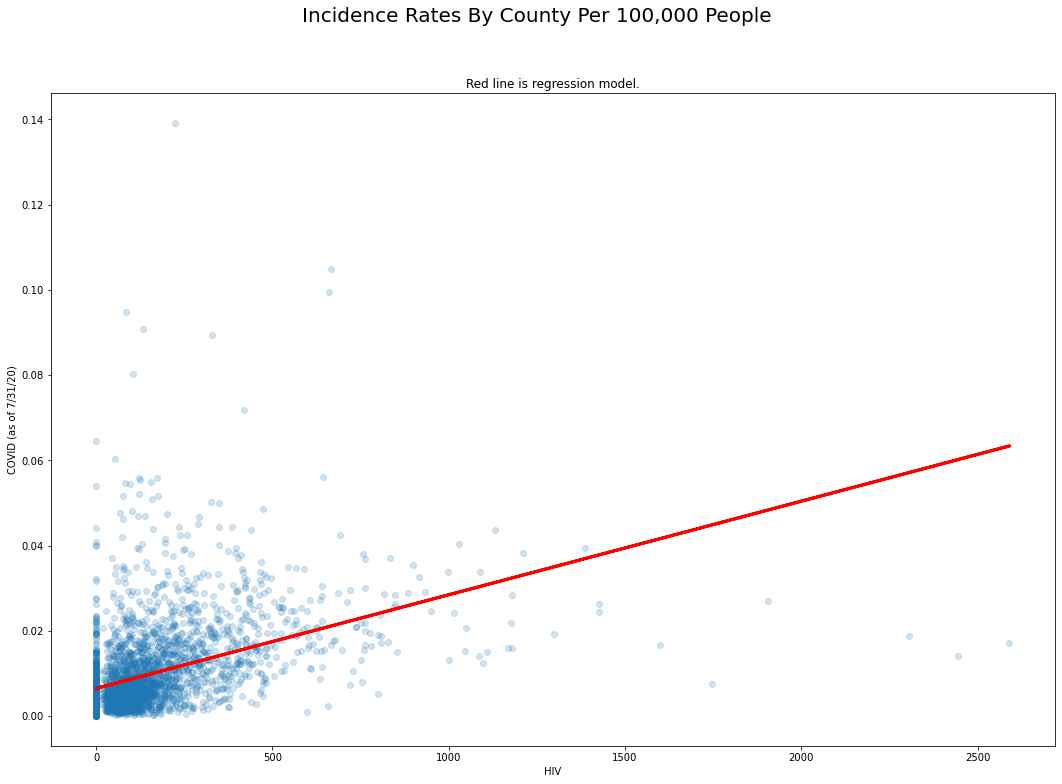

In [44]:
fig, ax = plt.subplots(figsize = (18, 12))
X = hiv_cov['HIVprevalence'].values.reshape(-1,1)
y = hiv_cov['COVID_Incidence_Rate']
model = LinearRegression()
model.fit(X, y)
yhat = model.predict(X)
ax.plot(X, yhat, linewidth = 3, color = 'r')
ax.scatter((hiv_cov['HIVprevalence']), (hiv_cov['COVID_Incidence_Rate']), alpha = 0.2)
ax.set_xlabel('HIV')
ax.set_ylabel('COVID (as of 7/31/20)')
fig.suptitle('Incidence Rates By County Per 100,000 People', size=20)
ax.set_title(f'Red line is regression model.')

### KNN predictions and generate new visualizations

In [15]:
from sklearn.neighbors import KNeighborsRegressor
X = hiv_cov[['Lat', 'Long_']]

y_covid = hiv_cov['COVID_Incidence_Rate']
covid_KNN = KNeighborsRegressor(n_neighbors=10)
covid_KNN.fit(X, y_covid)
covid_yhat = covid_KNN.predict(X)

y_hiv = hiv_cov['HIVprevalence']
hiv_KNN = KNeighborsRegressor(n_neighbors=10)
hiv_KNN.fit(X, y_hiv)
hiv_yhat = hiv_KNN.predict(X)


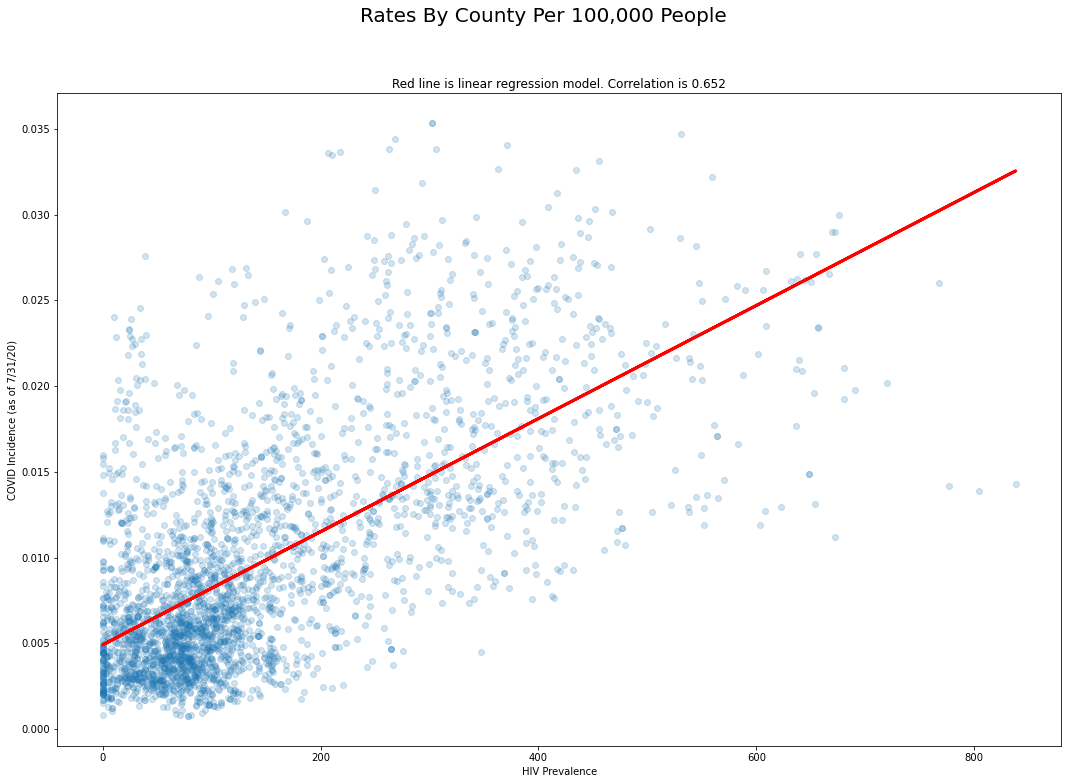

In [36]:
fig, ax = plt.subplots(figsize = (18, 12))
X = hiv_yhat.reshape(-1,1)
y = covid_yhat
model = LinearRegression()
model.fit(X, y)
yhat = model.predict(X)
ax.plot(X, yhat, linewidth = 3, color = 'r')
ax.scatter(hiv_yhat, covid_yhat, alpha = 0.2)
# ax.scatter(np.log(hiv_cov['HIVprevalence']), np.log(hiv_cov['COVID_Incidence_Rate']), alpha = 0.2)
ax.set_xlabel('HIV Prevalence')
ax.set_ylabel('COVID Incidence (as of 7/31/20)')
fig.suptitle('Rates By County Per 100,000 People', size=20)
ax.set_title(f'Red line is linear regression model. Correlation is {pd.Series(hiv_yhat).corr(pd.Series(covid_yhat)):.3}')
plt.savefig('img/prediction-scatterplot.png')


In [28]:
hiv_cov['covid_epidemic_prediction'] = covid_yhat
hiv_cov['hiv_epidemic_prediction'] = hiv_yhat

In [37]:
fig = px.choropleth_mapbox(hiv_cov, geojson=counties, locations='FIPS', color='covid_epidemic_prediction',
                           color_continuous_scale="Viridis",
                           range_color=(0, 0.022),
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'covid_epidemic_prediction':'COVID Incidence Prediction Based on Neighboring Counties'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image("img/covid_epidemic_prediction.png")
fig.write_html('img/covid_epidemic_prediction.html', auto_open=True)

In [38]:
fig = px.choropleth_mapbox(hiv_cov, geojson=counties, locations='FIPS', color='hiv_epidemic_prediction',
                           color_continuous_scale="Viridis",
                           range_color=(0, 325),
                           mapbox_style="carto-positron",
                           zoom=3, center = {"lat": 37.0902, "lon": -95.7129},
                           opacity=0.5,
                           labels={'hiv_epidemic_prediction':'HIV Prevalence Prediction Based on Neighboring Counties'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.write_image("img/hiv_epidemic_prediction.png")
fig.write_html('img/hiv_epidemic_prediction.html', auto_open=True)

## Results
- Regionalization improved the correlation of the maps. 
- 